In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from torch import nn
from collections import defaultdict

# Data loading and Cleaning

In [3]:
path = Path('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test')
path.ls()

[PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/NewLabels'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/Images'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/models'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/valid.txt')]

In [4]:
path_img = path/'Images' #should later be provided through ini file
path_lbl = path/'NewLabels' #should later be provided through ini file
path_img
path_lbl

PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/NewLabels')

In [6]:
img_names=get_image_files(path_img)
img_names[:3]
lbl_names=get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/NewLabels/BM1_0833.tif'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/NewLabels/BM3_1364.tif'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/NewLabels/BM1_x_0128.tif')]

In [7]:
def get_mask(img):
    return (path_lbl)/img.name

In [8]:
"""function to filter out images that only contain background; used to calculate appropriate weights; 
function returns the images that also contain seed in a list"""
def filter_background(img_list):
    include=[]
    for img in img_list:
        mask = open_mask(get_mask(img))
        count_total=(torch.unique(mask.data, return_counts=True))
        if not count_total[0].tolist() == [0]:
            include.append(img)
    return include

In [9]:
"""function to filter out images that only contain background; used to filter in the data block API; 
function has to return a boolean
slow, every mask has to be opened to check the values"""
def check_back(img):
    mask = open_mask(get_mask(img))
    count_total=(torch.unique(mask.data, return_counts=True))
    if not count_total[0].tolist() == [0]:
        return True
    else:
        return False

In [10]:
#mask = open_mask(get_mask(img_names[300]))
#mask.data
#count_total=(torch.unique(mask.data, return_counts=True))
#count_total[0].tolist()
#len(img_names)

In [11]:
#include = filter_background(img_names)
#len(include)
#mask.show()

In [12]:
#img_list2
#img = open_image(img_names[1])
#img.show()
#src_size = np.array(mask.shape[1:])
#src_size,mask.data

In [13]:
def count_mask(img_list):
    img_list = filter_background(img_list)
    count_classes = defaultdict(int)
    for img in img_list:
        #return the occurence of every class in the mask for an image
        mask = open_mask(get_mask(img))
        count_total = torch.unique(mask.data, return_counts=True)
        classes=count_total[0].tolist()
        count_real=count_total[1].tolist()
        for x, y in zip(classes, count_real):
            count_classes[x] += y
    return count_classes

In [14]:
%time classes_count = count_mask(img_names)
classes_count
#slow for big sets, make faster?

CPU times: user 3h 36min 24s, sys: 12min 58s, total: 3h 49min 22s
Wall time: 7min 12s


defaultdict(int, {0: 5172245972, 1: 1746988299, 2: 183613959, 3: 149740758})

In [15]:
#append occurences in a list 
#seems redundant
counts = []
for c in classes_count:
    counts.append(classes_count[c])
counts

[5172245972, 1746988299, 183613959, 149740758]

In [16]:
weight_ratios =[min(counts)/x for x in counts]
weight_ratios

[0.028950819201295323, 0.08571365823441042, 0.8155194671228673, 1.0]

In [17]:
np.random.seed(42)
#slow with large data set
src = (SegmentationItemList.from_folder(path)
       .filter_by_func(check_back)
       .split_by_fname_file('valid.txt')
       .label_from_func(get_mask, classes=list(range(4))))

In [18]:
src

LabelLists;

Train: LabelList (6488 items)
x: SegmentationItemList
Image (3, 668, 864),Image (3, 2381, 864),Image (3, 2381, 864),Image (3, 2381, 668),Image (3, 668, 864)
y: SegmentationLabelList
ImageSegment (1, 668, 864),ImageSegment (1, 2381, 864),ImageSegment (1, 2381, 864),ImageSegment (1, 2381, 668),ImageSegment (1, 668, 864)
Path: /home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test;

Valid: LabelList (6600 items)
x: SegmentationItemList
Image (3, 678, 931),Image (3, 678, 931),Image (3, 2183, 678),Image (3, 678, 931),Image (3, 678, 931)
y: SegmentationLabelList
ImageSegment (1, 678, 931),ImageSegment (1, 678, 931),ImageSegment (1, 2183, 678),ImageSegment (1, 678, 931),ImageSegment (1, 678, 931)
Path: /home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test;

Test: None

In [19]:
%time data = (src.transform(get_transforms(), tfm_y=True, size=128).databunch(bs=8).normalize())

CPU times: user 14.2 s, sys: 1.33 s, total: 15.5 s
Wall time: 2.72 s


In [20]:
data

ImageDataBunch;

Train: LabelList (6488 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: /home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test;

Valid: LabelList (6600 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: /home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test;

Test: None

In [21]:
#data.show_batch(4, figsize=(10,7))

# Learning

In [22]:
#from Nikos
#based of fastai foreground_acc
def acc_seeds(input, target):
    target = target.squeeze(1)
    mask = target != 0 #not interested in background
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [23]:
metrics=acc_seeds
wd=1e-2

In [24]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [25]:
#set class weights
class_weights=torch.FloatTensor(weight_ratios)
learn.crit = nn.CrossEntropyLoss(weight=class_weights)

In [26]:
#lr_find(learn)
#learn.recorder.plot()

In [27]:
lr = 1e-4

In [28]:
lrs = slice(lr/100,lr)

In [29]:
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,acc_seeds,time
0,0.190907,0.127937,0.938806,32:56
1,0.073547,0.059257,0.964613,31:47
2,0.059780,0.049940,0.969285,31:52
3,0.041512,0.043719,0.971534,31:31


In [30]:
#learn.summary()

In [31]:
#learn.save('stage-small_1')

In [32]:
#learn.load('stage-small_1');

In [33]:
#learn.unfreeze()

In [34]:
#learn.fit_one_cycle(2, lrs)

In [35]:
#learn.save('stage-small_2')

In [36]:
#data_med = (src.transform(get_transforms(), tfm_y=True, size=256)
#       .databunch(bs=8)
#       .normalize())

In [37]:
#learn = unet_learner(data_med, models.resnet34, metrics=metrics, wd=wd)
#learn.crit = nn.CrossEntropyLoss(weight=class_weights)

In [38]:
#learn.load('stage-small_1');

In [39]:
#learn.unfreeze()

In [40]:
#learn.fit_one_cycle(2, lrs)

In [41]:
#learn.show_results()

In [42]:
#learn.save('stage-med_1')

In [43]:
#data_L = (src.transform(get_transforms(), tfm_y=True, size=300)
#       .databunch(bs=8)
#       .normalize())

In [44]:
#learn.load('stage-med_1');

In [45]:
#learn.unfreeze()

In [46]:
#learn.fit_one_cycle(2, lrs)

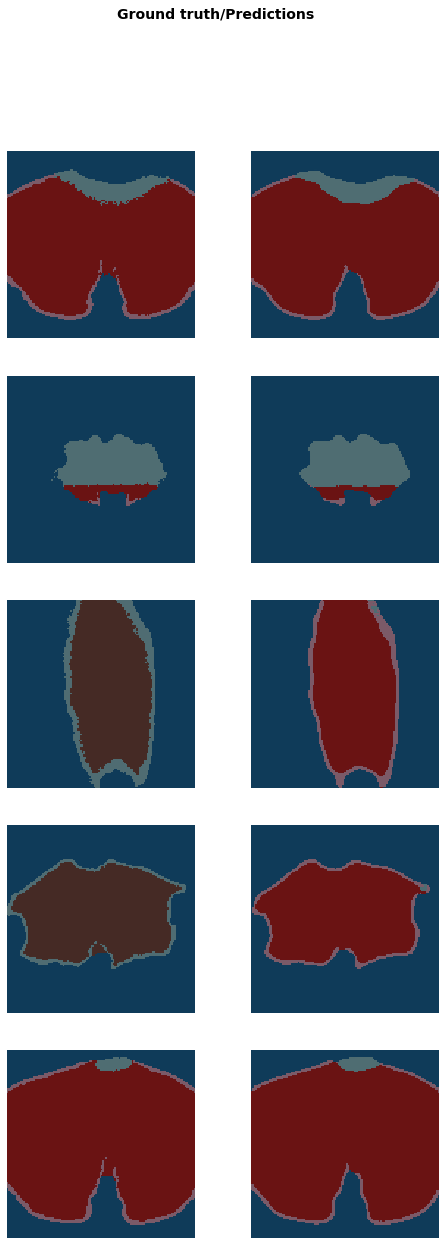

In [47]:
learn.show_results()

In [48]:
from fastai.vision.interpret import *
interp = SegmentationInterpretation.from_learner(learn)
#interp = Interpretation.from_learner(learn)
#interp

In [49]:
top_losses, top_idxs = interp.top_losses(sizes=(128,128))
top_idxs

tensor([4988, 3468, 5258,  ..., 4298, 4566, 6274])

In [50]:
learn.data.classes

[0, 1, 2, 3]

In [51]:
mean_cm, single_img_cm = interp._generate_confusion()

label,score
0.0,0.995086
1.0,0.957372
2.0,0.815844
3.0,0.793487


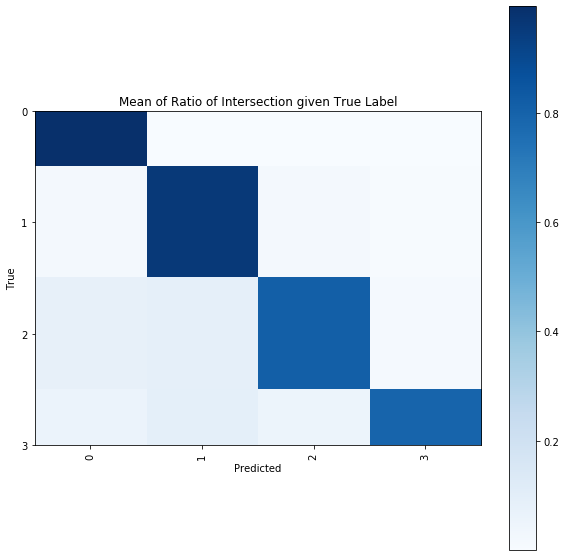

In [52]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [53]:
#len(single_img_cm)

label,score
0.0,1.000000
2.0,0.869338
1.0,0.683051
3.0,0.500000


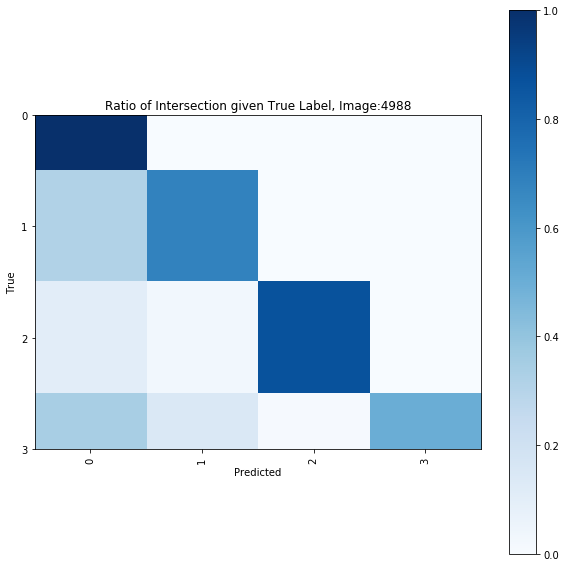

In [54]:
# Look at single worst performing picture
i = top_idxs[0]
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

In [55]:
def _interp_show_new(self, ims:ImageSegment, classes:Collection=None, sz:int=20, cmap='tab20',
                    title_suffix:str=None):
        "Show ImageSegment with color mapping labels"
        fig,axes=plt.subplots(1,2,figsize=(sz,sz))
        np_im = to_np(ims.data).copy()
        # tab20 - qualitative colormaps support max of 20 distinc colors
        # if len(classes) > 20 close idxs map to same color
        # image
        if classes is not None:
            class_idxs = [self.c2i[c] for c in classes]
            mask = np.max(np.stack([np_im==i for i in class_idxs]),axis=0)
            np_im = (np_im*mask).astype(np.float)
            np_im[np.where(mask==0)] = np.nan
        im=axes[0].imshow(np_im[0], cmap=cmap)

        # labels
        np_im_labels = list(np.unique(np_im[~np.isnan(np_im)]))
        c = len(np_im_labels); n = math.ceil(np.sqrt(c))
        label_im = np.array(np_im_labels + [np.nan]*(n**2-c)).reshape(n,n)
        axes[1].imshow(label_im, cmap=cmap)
        for i,l in enumerate([self.i2c[l] for l in np_im_labels]):
            div,mod=divmod(i,n)
            #l = "\n".join(wrap(l,10)) if len(l) > 10 else l
            axes[1].text(mod, div, f"{l}", ha='center', color='white', fontdict={'size':sz})

        if title_suffix:
            axes[0].set_title(f"{title_suffix}_imsegment")
            axes[1].set_title(f"{title_suffix}_labels")

In [56]:
import types
def show_xyz_new(self, i, classes:list=None, sz=10):
        'show (image, true and pred) from self.ds with color mappings, optionally only plot'
        funcType = types.MethodType
        self._interp_show = funcType(_interp_show_new, self)
        x,y = self.ds[i]
        self.ds.show_xys([x],[y], figsize=(sz/2,sz/2))
        self._interp_show(ImageSegment(self.y_true[i]), classes, sz=sz, title_suffix='true')
        self._interp_show(ImageSegment(self.pred_class[i][None,:]), classes, sz=sz, title_suffix='pred')

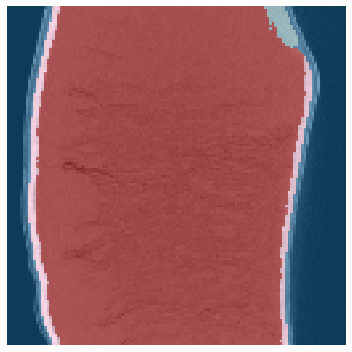

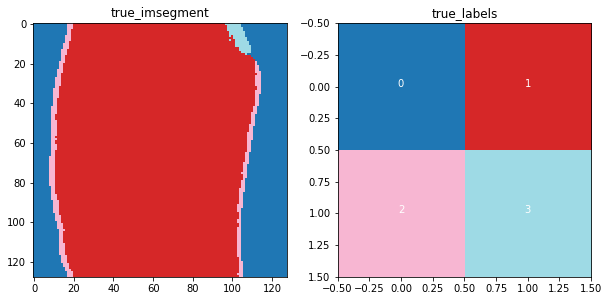

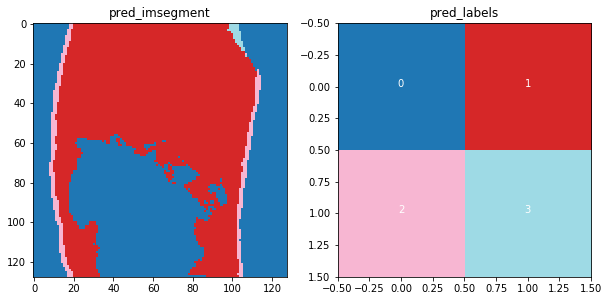

In [57]:
funcType = types.MethodType
interp.show_xyz = funcType(show_xyz_new, interp)
interp.show_xyz(i)